In [1]:
import pandas as pd 
import numpy as np 
from pathlib import Path
import gpboost as gpb
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.style.use('ggplot') 

In [2]:
data = np.load(Path().resolve().parents[1] / f"data/chrome_data.npy", allow_pickle=True)[()]


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['X'], data['y'], random_state=123, train_size=0.8)

In [4]:
# create dataset for gpb.train
data_train = gpb.Dataset(X_train, y_train)
data_eval = gpb.Dataset(X_test, y_test, reference=data_train)

In [5]:
# specify your configurations as a dict
params = {
    'objective': 'regression_l2',
    'metric': {'l2', 'l1'},
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_data_in_leaf': 5,
    'verbose': 0
}

[1]	valid_0's l1: 16321.5	valid_0's l2: 4.54094e+08
[2]	valid_0's l1: 14682.2	valid_0's l2: 3.70676e+08
[3]	valid_0's l1: 13218.5	valid_0's l2: 3.00991e+08
[4]	valid_0's l1: 11659.2	valid_0's l2: 2.36585e+08
[5]	valid_0's l1: 10532.4	valid_0's l2: 1.98911e+08
[6]	valid_0's l1: 9559.7	valid_0's l2: 1.71036e+08
[7]	valid_0's l1: 8759.71	valid_0's l2: 1.51316e+08
[8]	valid_0's l1: 8171.5	valid_0's l2: 1.36776e+08
[9]	valid_0's l1: 7622.41	valid_0's l2: 1.25856e+08
[10]	valid_0's l1: 7147.77	valid_0's l2: 1.20482e+08
[11]	valid_0's l1: 6918.9	valid_0's l2: 1.23636e+08
[12]	valid_0's l1: 6580.82	valid_0's l2: 1.21196e+08
[13]	valid_0's l1: 6493.85	valid_0's l2: 1.31804e+08
[14]	valid_0's l1: 6231.43	valid_0's l2: 1.31152e+08
[15]	valid_0's l1: 6194.32	valid_0's l2: 1.4585e+08
Early stopping, best iteration is:
[10]	valid_0's l1: 7147.77	valid_0's l2: 1.20482e+08


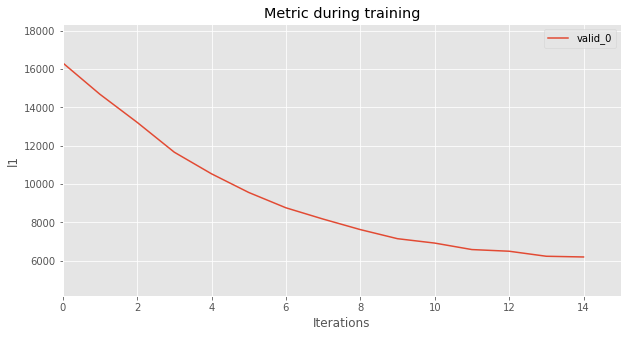

In [6]:
# train
evals_result = {}  # record eval results for plotting
bst = gpb.train(params=params,
                train_set=data_train,
                num_boost_round=1000,
                valid_sets=data_eval,
                early_stopping_rounds=5,
                evals_result = evals_result)

# plot validation scores
gpb.plot_metric(evals_result, metric='l1', figsize=(10, 5))
plt.show()

In [7]:
# predict
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

print('The r2_score of prediction is:', r2_score(y_test, y_pred))

The rmse of prediction is: 10976.413046060386
The r2_score of prediction is: 0.785320452353341


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

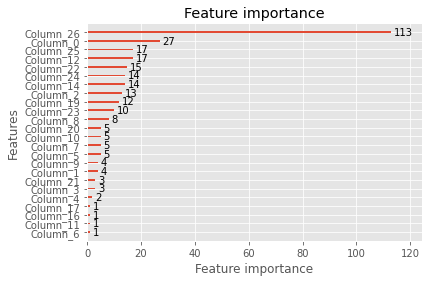

In [8]:
gpb.plot_importance(bst)

In [9]:
gp_model = gpb.GPModel(group_data=X_train[:, 22],
                       likelihood="gaussian", 
                       cov_function='exponential')
# train
bst = gpb.GPBoostRegressor(max_depth=-1,
                           learning_rate=0.05,
                           min_data_in_leaf=5,
                           num_boost_round=1000,
                           n_estimators=100)


In [10]:
bst.fit(X_train, y_train, gp_model=gp_model)
print("Estimated random effects model")
gp_model.summary()


/Users/mamu867/.virtualenvs/UQ_AL/lib/python3.8/site-packages/gpboost/engine.py:174: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[GPBoost] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[GPBoost] [Warning] num_iterations is set=1000, num_boost_round=1000 will be ignored. Current value: num_iterations=1000
Estimated random effects model
Covariance parameters 
['Error_term', 'Group_1']
[7.87332739e+08 7.49896955e+07]


In [11]:
print('Starting predicting...')
# predict
pred = bst.predict(X=X_test, group_data_pred=X_test[:, 22])

Starting predicting...


In [12]:
pred.keys()

dict_keys(['fixed_effect', 'random_effect_mean', 'random_effect_cov', 'response_mean', 'response_var'])

In [13]:
y_pred = pred['fixed_effect'] + pred['random_effect_mean']

In [14]:
print('The r2_score of prediction is:', r2_score(y_test, y_pred))

The r2_score of prediction is: -0.002146415265764201


In [15]:
gp_model = gpb.GPModel(gp_coords=X_train, cov_function="exponential")
data_train = gpb.Dataset(X_train, y_train)
params = { 'objective': 'regression_l2', 'learning_rate': 0.01,
            'max_depth': 8, 'min_data_in_leaf': 10, 
            'num_leaves': 2**10, 'verbose': 0 }
# Training
bst = gpb.train(params=params, train_set=data_train,
                gp_model=gp_model, num_boost_round=1000)
gp_model.summary() # Estimated covariance parameters
# Prediction
pred = bst.predict(data=X_test, gp_coords_pred=X_test,
                    predict_var=True)
# Sum the predictions of the trees and the GP
y_pred = pred['fixed_effect'] + pred['random_effect_mean']
print('The r2_score of prediction is:', r2_score(y_test, y_pred))

Covariance parameters 
['Error_term', 'GP_var', 'GP_range']
[3.94926982e+05 2.70416131e+11 5.40334822e+03]
The r2_score of prediction is: 0.6409387550294596


In [16]:
pred['fixed_effect']

array([17306.52022935, 17306.52009928, 17306.52009928, 17306.52008591,
       17306.5202121 , 17306.5212258 , 17306.52041517, 17306.52167873,
       17306.52009928, 17306.52022935, 17306.51988157, 17306.5202121 ,
       17306.5197568 , 17306.52010019, 17306.52088305, 17306.5202121 ,
       17306.52041517, 17306.52030464, 17306.5193904 , 17306.5204156 ,
       17306.52056327, 17306.52009928, 17306.52030464, 17306.52032235,
       17306.52041517, 17306.52056134, 17306.52178409, 17306.52030464,
       17306.52032235, 17306.52030464, 17306.52030916, 17306.52039473,
       17306.52009928, 17306.5201506 , 17306.52030464, 17306.52028242,
       17306.52034232, 17306.51989781, 17306.52009928, 17306.5201506 ,
       17306.52005032, 17306.52021102, 17306.52008591, 17306.52000553,
       17306.5193904 , 17306.52002799, 17306.52041517, 17306.52008591,
       17306.52000553, 17306.52022935, 17306.52178409, 17306.52041517,
       17306.52022935, 17306.52008591, 17306.52005032, 17306.52001959,
      

In [18]:
bst.predict(X_train, gp_coords_pred=X_train)

{'fixed_effect': array([17306.52025628, 17306.5201506 , 17306.5202121 , 17306.52001959,
        17306.5202121 , 17306.5201506 , 17306.52030916, 17306.52025628,
        17306.52013722, 17306.52041517, 17306.5202121 , 17306.52010019,
        17306.52028242, 17306.52030464, 17306.52178409, 17306.52009928,
        17306.52034232, 17306.52009928, 17306.52056327, 17306.52034232,
        17306.5212258 , 17306.52009928, 17306.52022935, 17306.52056134,
        17306.52001959, 17306.5202121 , 17306.52009928, 17306.5201506 ,
        17306.52028242, 17306.52041517, 17306.51978908, 17306.51988157,
        17306.5202121 , 17306.5206141 , 17306.52178409, 17306.52008591,
        17306.52009928, 17306.51976486, 17306.52056327, 17306.52030464,
        17306.52009928, 17306.52056134, 17306.52008591, 17306.52010019,
        17306.5212258 , 17306.52013722, 17306.52036472, 17306.52030464,
        17306.5202121 , 17306.5202121 , 17306.52009928, 17306.52034232,
        17306.52013722, 17306.52009928, 17306.52